# Orlando

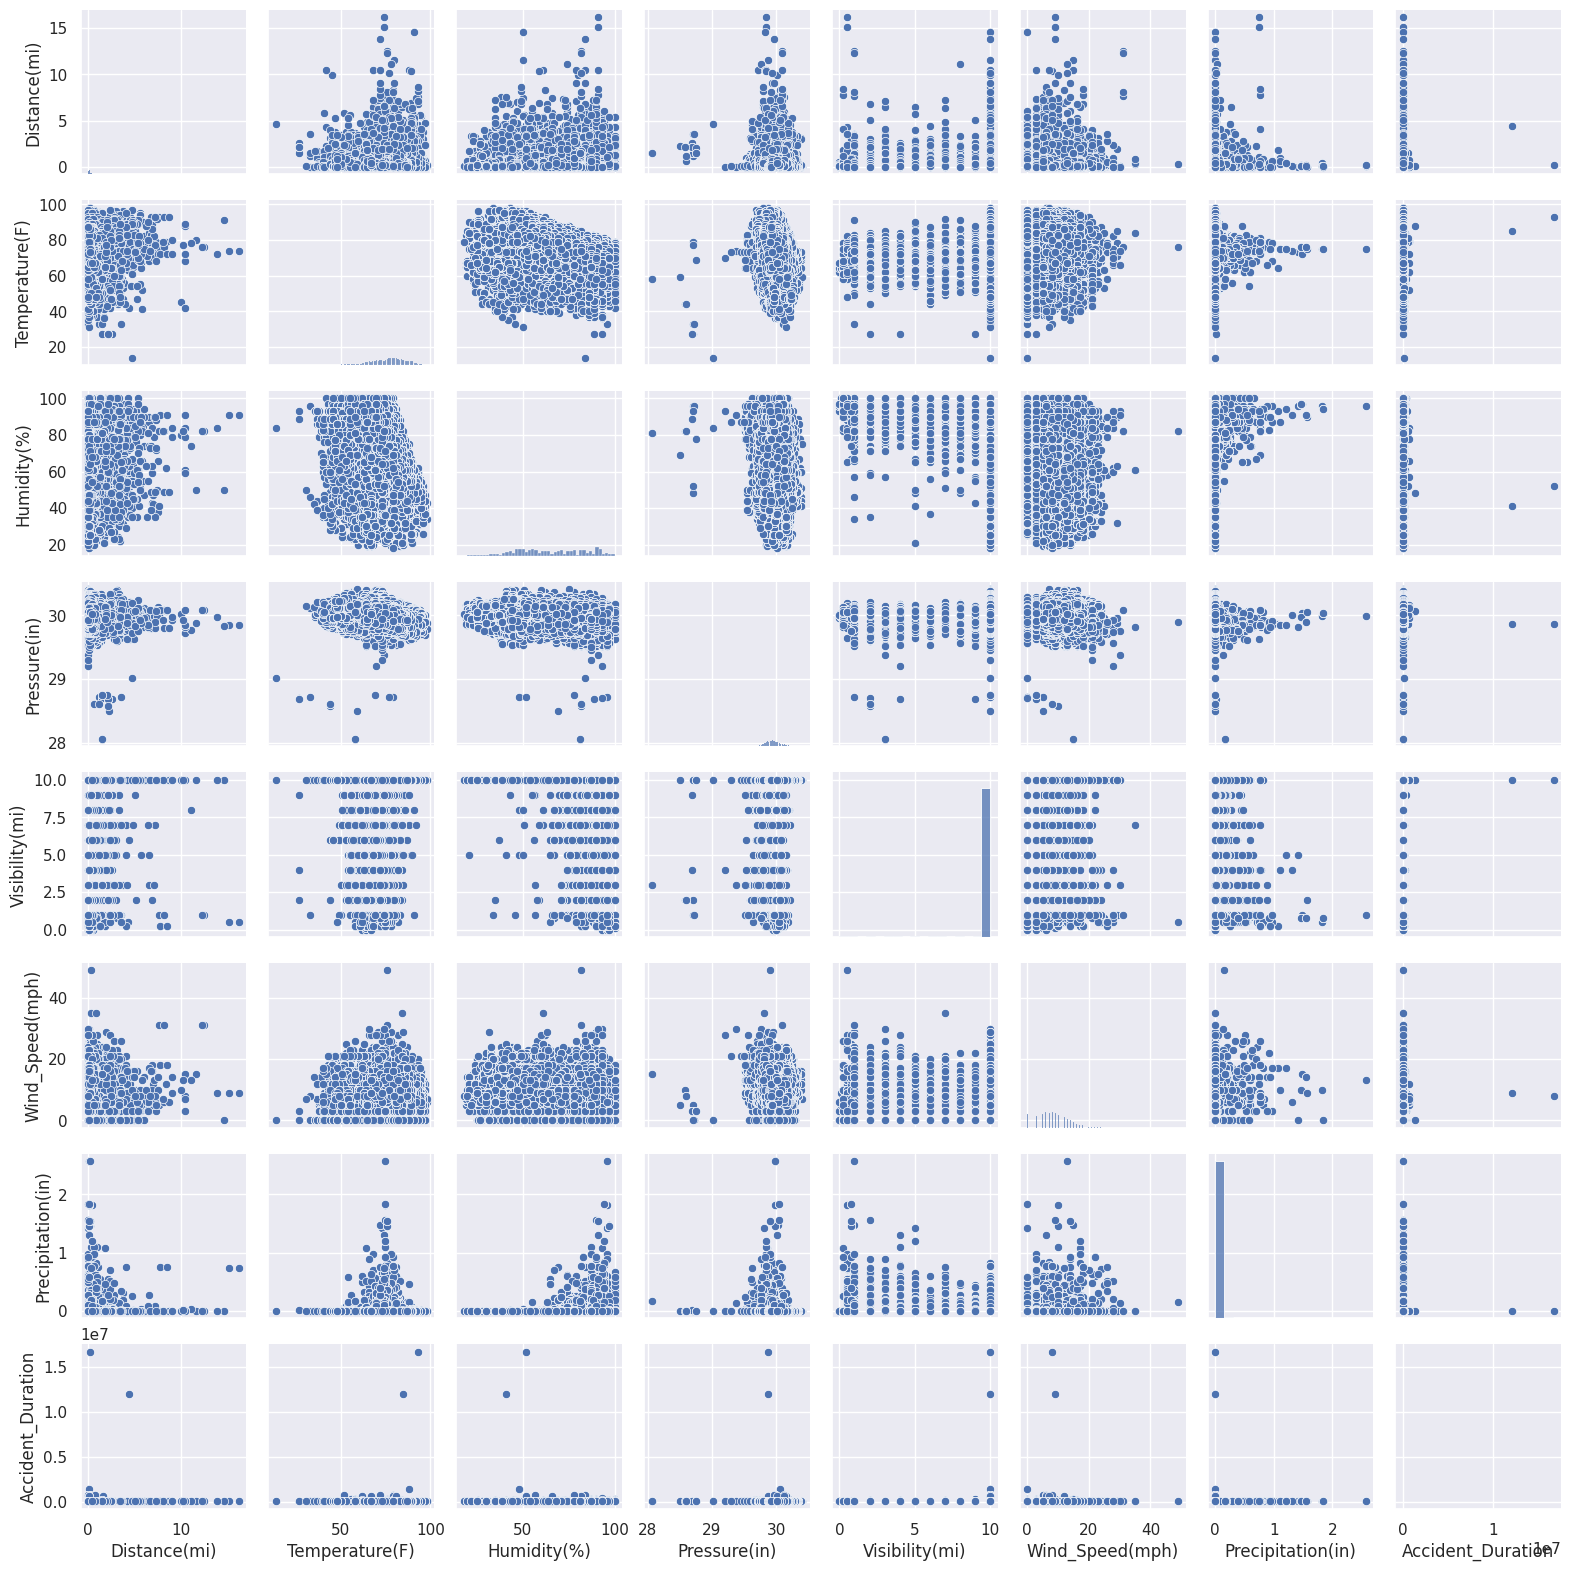

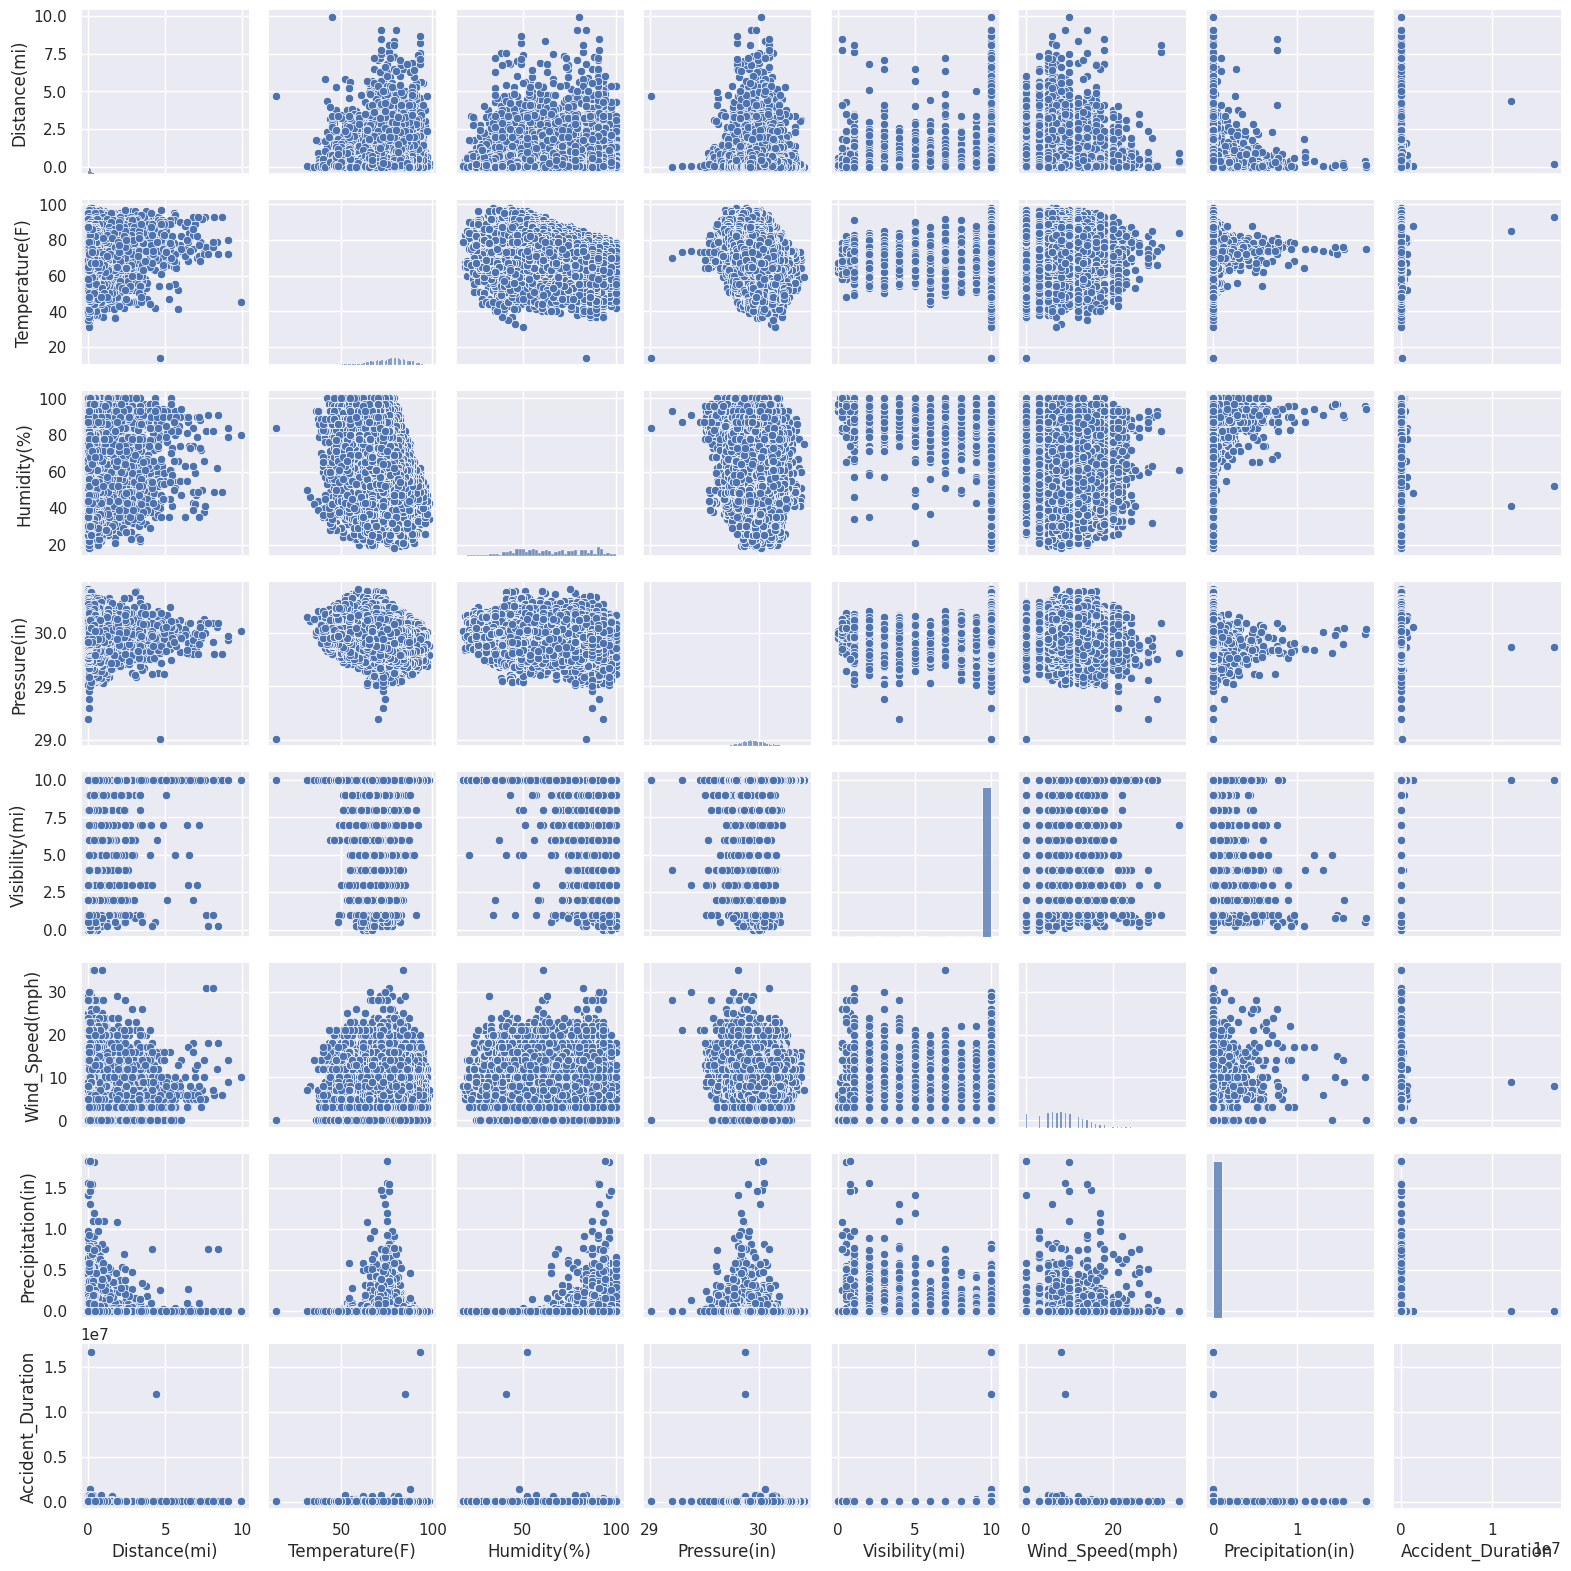

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.read_csv("Orlando_accidents.csv").sort_values("Start_Time")
df = df.drop(["Accident_Duration_Hours","Accident_Duration_Minutes","Accident_Duration_Seconds","Wind_Chill(F)"],axis=1)
df.drop(["Start_Lat","Start_Lng","End_Lat","End_Lng"],axis=1).describe()
categorical_df = df.select_dtypes(include=["object"])
numerical_df = df.select_dtypes(include=["float64","int64"])
bool_df = df.select_dtypes(include=["bool"]) * 1 
numerical_df = numerical_df.fillna(method="backfill")
df = categorical_df.join(numerical_df).join(bool_df).reset_index(drop=True)

sns.set(rc = {'figure.figsize':(20,10)})
cols = ['Distance(mi)','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Accident_Duration']
sns.pairplot(df[cols], size = 2)
plt.show();
df = df.drop(df[df["Distance(mi)"]>10].index)
df = df.drop(df[df["Pressure(in)"]<29].index)
df = df.drop(df[df["Wind_Speed(mph)"]>40].index)
df = df.drop(df[df["Precipitation(in)"]>2].index)
sns.set(rc = {'figure.figsize':(20,10)})
cols = ['Distance(mi)','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Accident_Duration']
sns.pairplot(df[cols], size = 2)
plt.show();

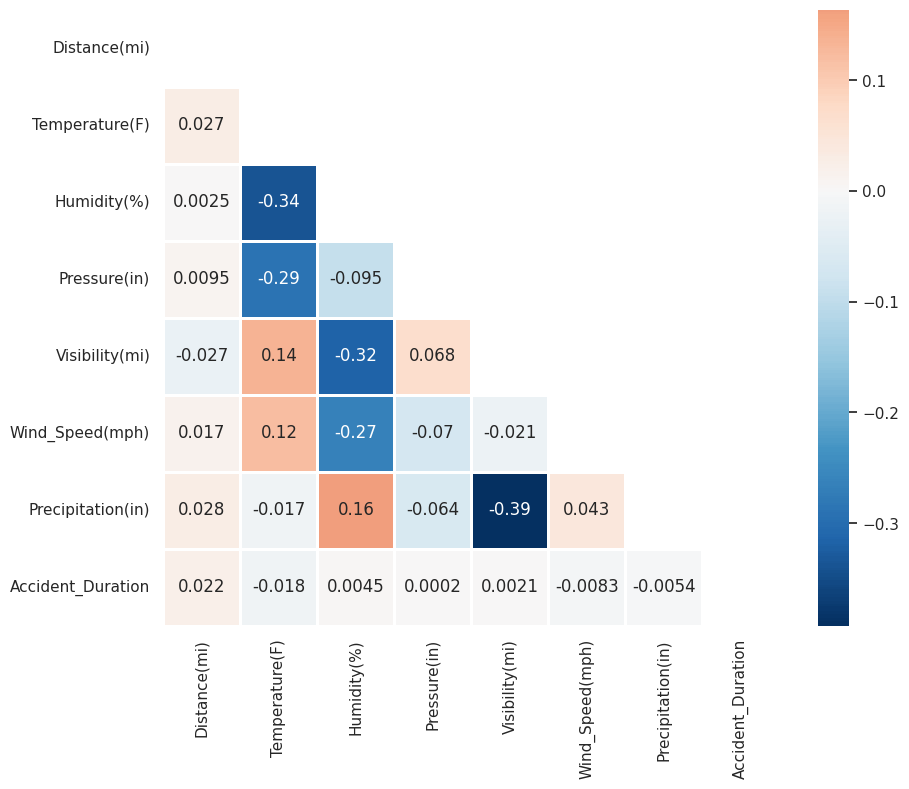

In [2]:
mask = np.zeros_like(df[cols].corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (10,8))
sns.heatmap(df[cols].corr(),annot=True,mask = mask,cmap = 'RdBu_r',linewidths=.9,linecolor='white', fmt='.2g',center = 0,square=True);

In [3]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

include_cols = ['Airport_Code','Wind_Direction','Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Severity','Distance(mi)', 'Temperature(F)','Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way','Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop','Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Year','Month','Day','Hour','Weekday']
X = df[include_cols]
y = df['Accident_Duration']
X = pd.get_dummies(X,drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_std = scalar.fit_transform(X_train) 
X_test_std = scalar.transform(X_test)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

rf_params = {'max_depth': randint(1,20), 'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1, 4)}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, cv=3, random_state=42, n_jobs=-1)
rf_random.fit(X_train_std,y_train)
best_params = rf_random.best_params_
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train_std, y_train)
y_pred_rf = best_rf.predict(X_test_std)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("rmse:",rmse_rf)
print("r2:",r2_rf)

rmse: 29501.510923331018
r2: -0.8140089938178054


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

def build_nn_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_std.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

nn_model = KerasRegressor(build_fn=build_nn_model, epochs=50, batch_size=10, verbose=0)
nn_model.fit(X_train_std, y_train)
y_pred_nn = nn_model.predict(X_test_std)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("rmse:",rmse_nn)
print("r2:",r2_nn)

2025-07-18 07:47:23.484948: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 07:47:23.548318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-18 07:47:23.548487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-18 07:47:23.550550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-18 07:47:23.558190: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 07:47:23.558946: I tensorflow/core/platform/cpu_feature_guard.cc:1

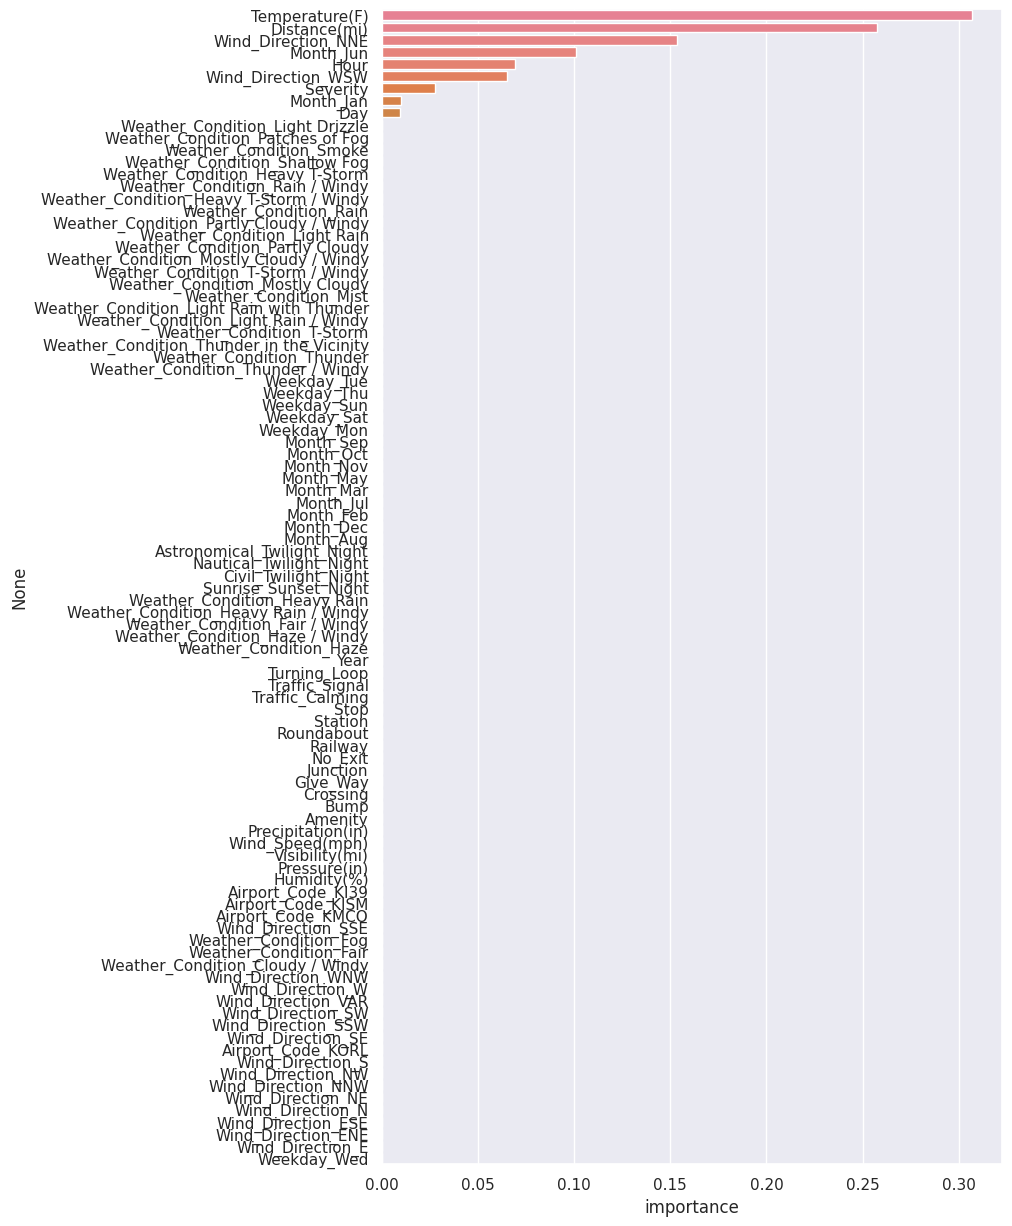

In [6]:
feature_importances = pd.DataFrame(best_rf.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

sns.set(rc = {'figure.figsize':(8,15)})
sns.barplot(y=feature_importances.index,x="importance",data=feature_importances,palette="husl");

# Los Angeles

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.ticker import FuncFormatter

from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

la = pd.read_csv("Los Angeles_accidents.csv")

In [8]:
la.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46118 entries, 0 to 46117
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         46118 non-null  object 
 1   Source                     46118 non-null  object 
 2   Severity                   46118 non-null  int64  
 3   Start_Time                 46118 non-null  object 
 4   End_Time                   46118 non-null  object 
 5   Start_Lat                  46118 non-null  float64
 6   Start_Lng                  46118 non-null  float64
 7   End_Lat                    35320 non-null  float64
 8   End_Lng                    35320 non-null  float64
 9   Distance(mi)               46118 non-null  float64
 10  Description                46117 non-null  object 
 11  Street                     46071 non-null  object 
 12  City                       46118 non-null  object 
 13  County                     46118 non-null  obj

In [9]:
la.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Accident_Duration,Accident_Duration_Hours,Accident_Duration_Minutes,Accident_Duration_Seconds
count,46118.000,46118.000,46118.000,35320.000,35320.000,46118.000,45897.000,45198.000,45865.000,45902.000,46063.000,45280.000,46114.000,46118.000,46118.000,46118.000,46118.000
mean,2.114,34.028,-118.275,34.025,-118.272,0.889,64.402,64.279,60.362,29.804,9.133,3.308,0.002,9735.264,2.268,25.757,25.784
std,0.341,0.054,0.079,0.056,0.082,1.835,9.563,9.580,21.543,0.160,1.998,3.966,0.020,15639.137,4.343,15.785,17.459
min,1.000,33.902,-118.503,33.834,-118.546,0.000,38.000,37.000,4.000,28.810,0.000,0.000,0.000,180.000,0.000,0.000,0.000
25%,2.000,33.989,-118.305,33.986,-118.306,0.019,57.000,57.000,47.000,29.720,10.000,0.000,0.000,2715.000,0.000,14.000,10.000
50%,2.000,34.032,-118.271,34.031,-118.269,0.175,64.000,64.000,64.000,29.800,10.000,3.000,0.000,6262.000,1.000,24.000,30.000
75%,2.000,34.056,-118.222,34.055,-118.222,0.814,71.000,70.000,78.000,29.900,10.000,6.000,0.000,9155.750,2.000,38.000,39.000
max,4.000,34.158,-118.121,34.296,-117.885,19.728,103.000,103.000,100.000,30.310,10.000,32.000,0.620,709080.000,196.000,59.000,59.000


In [10]:
la = la.drop(columns = ['ID', 'Source', 'End_Time', 'End_Lat', 'End_Lng', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Turning_Loop', 'Nautical_Twilight', 'Civil_Twilight', 'Astronomical_Twilight', 'Accident_Duration_Hours', 'Accident_Duration_Minutes', 'Accident_Duration_Seconds'])

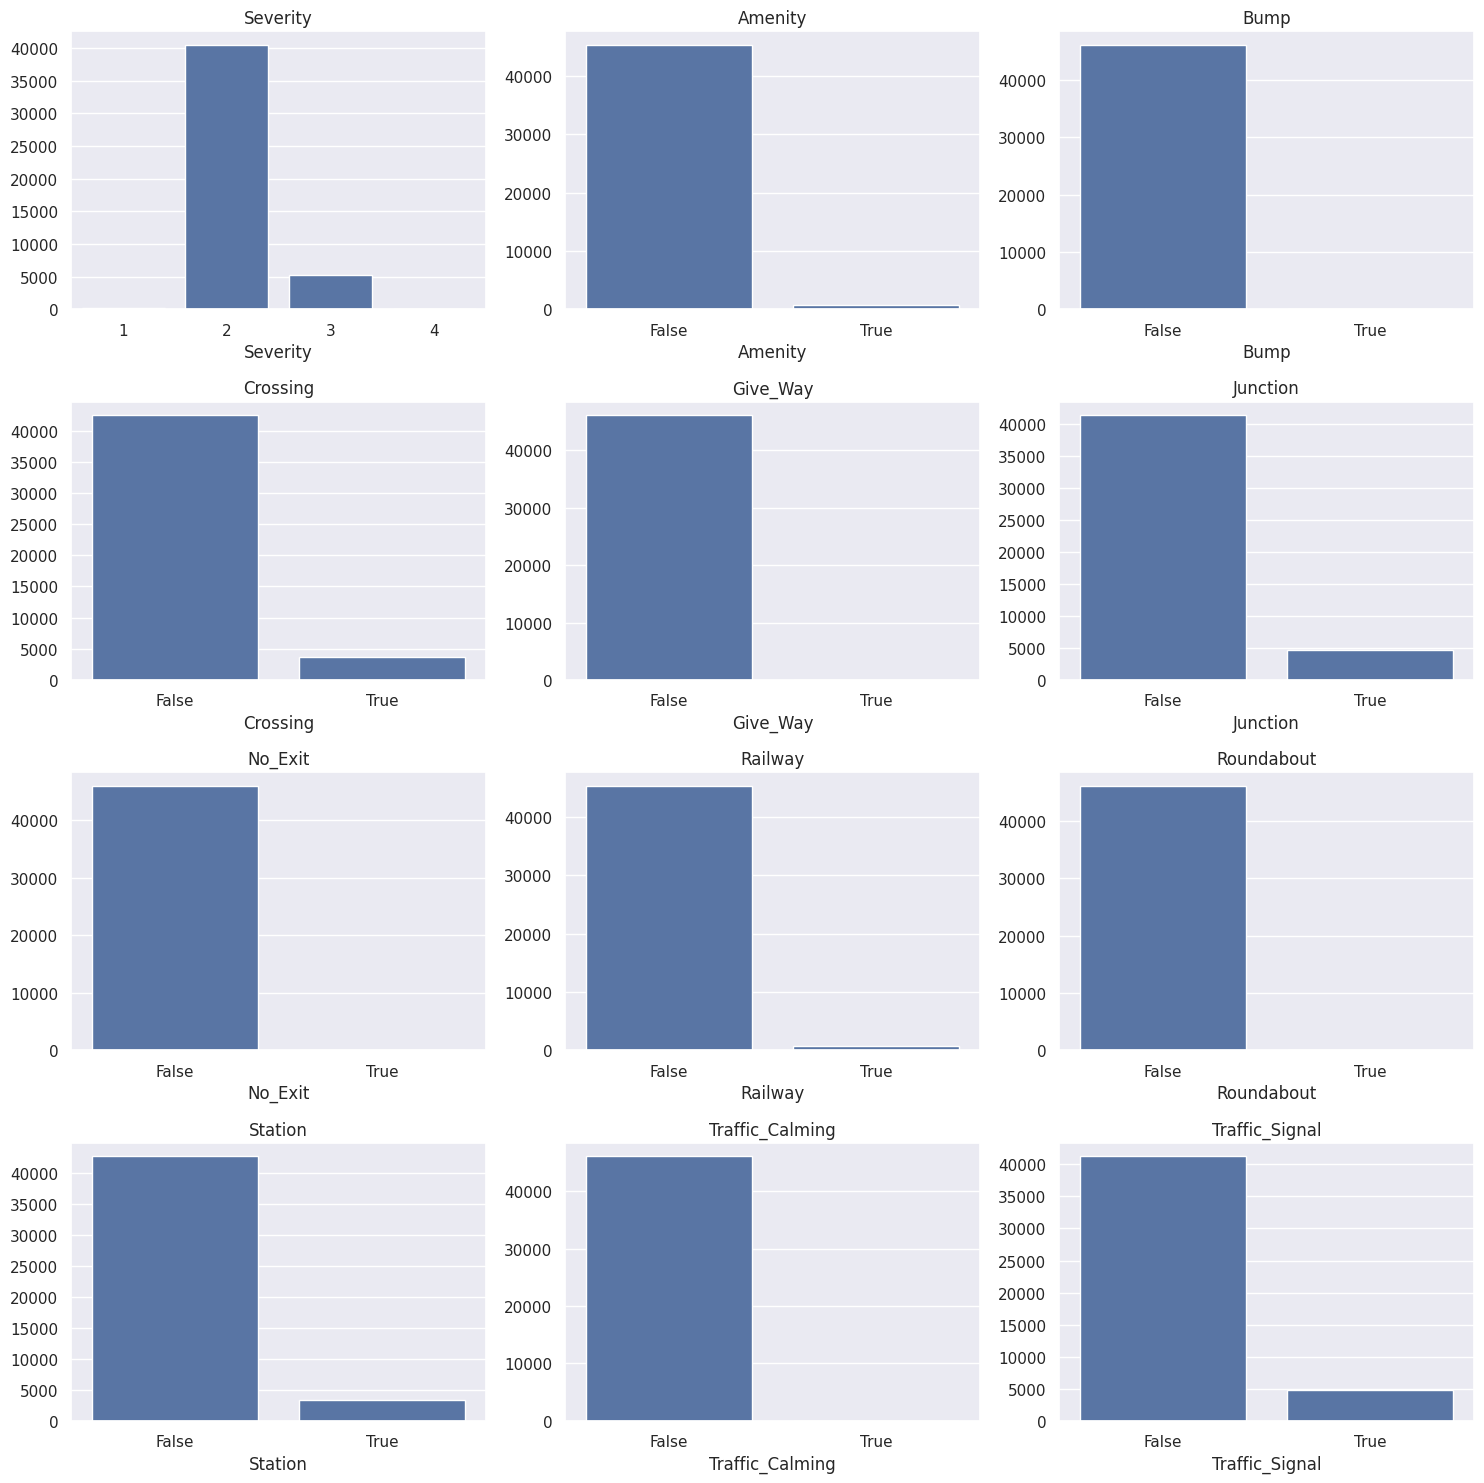

In [11]:
categorical_features = ['Severity', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Traffic_Calming', 'Traffic_Signal']

fig, axes = plt.subplots(4, 3, figsize = (15, 15), sharex = False, sharey = False)

count = 0
for col in categorical_features:
    value_counts = la[col].value_counts()
    x = count // 3
    y = count % 3
    sns.barplot(ax = axes[x, y], x = value_counts.index, y = value_counts.values)
    axes[x, y].set_title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

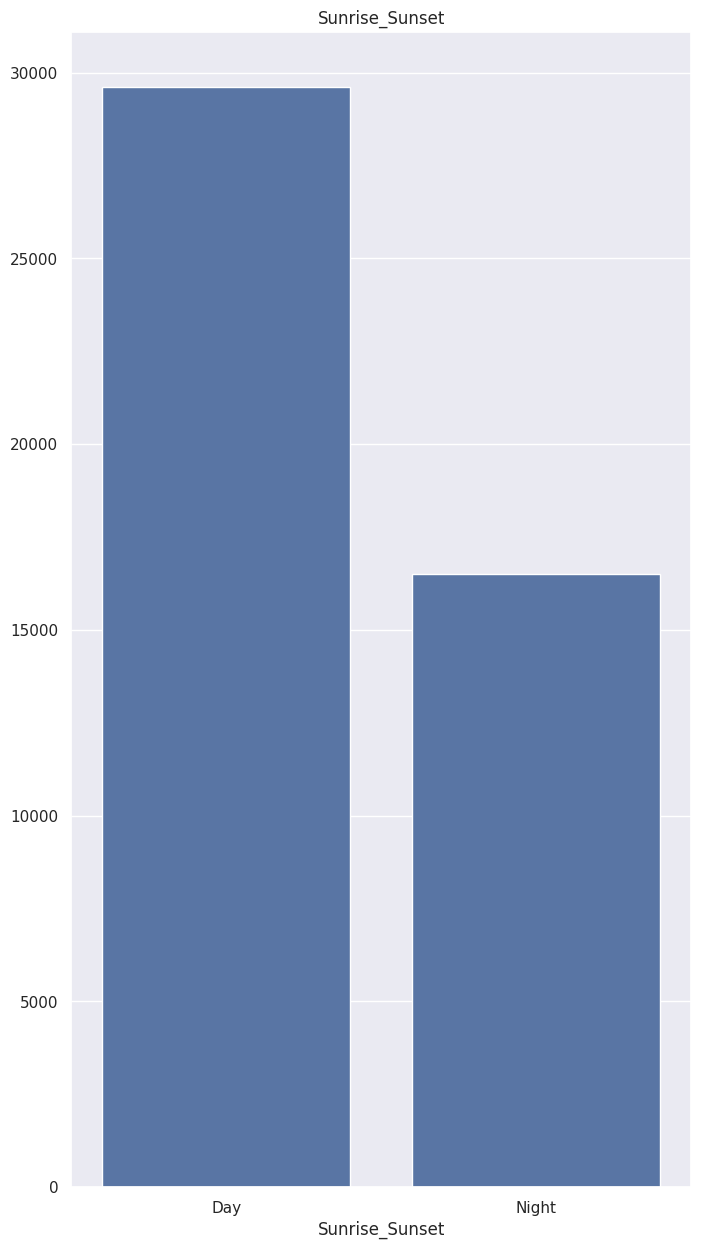

In [12]:
sns.barplot(x = la['Sunrise_Sunset'].value_counts().index, y = la['Sunrise_Sunset'].value_counts().values)
plt.title('Sunrise_Sunset');

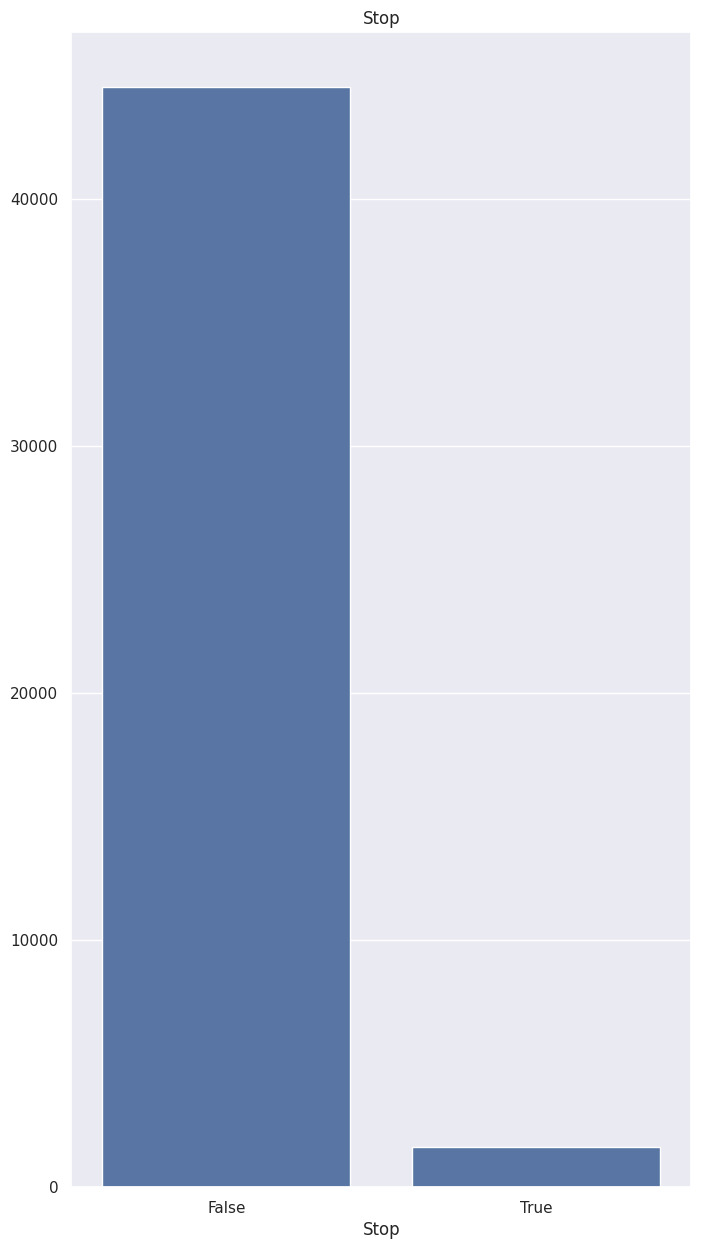

In [13]:
sns.barplot(x = la['Stop'].value_counts().index, y = la['Stop'].value_counts().values)
plt.title('Stop');

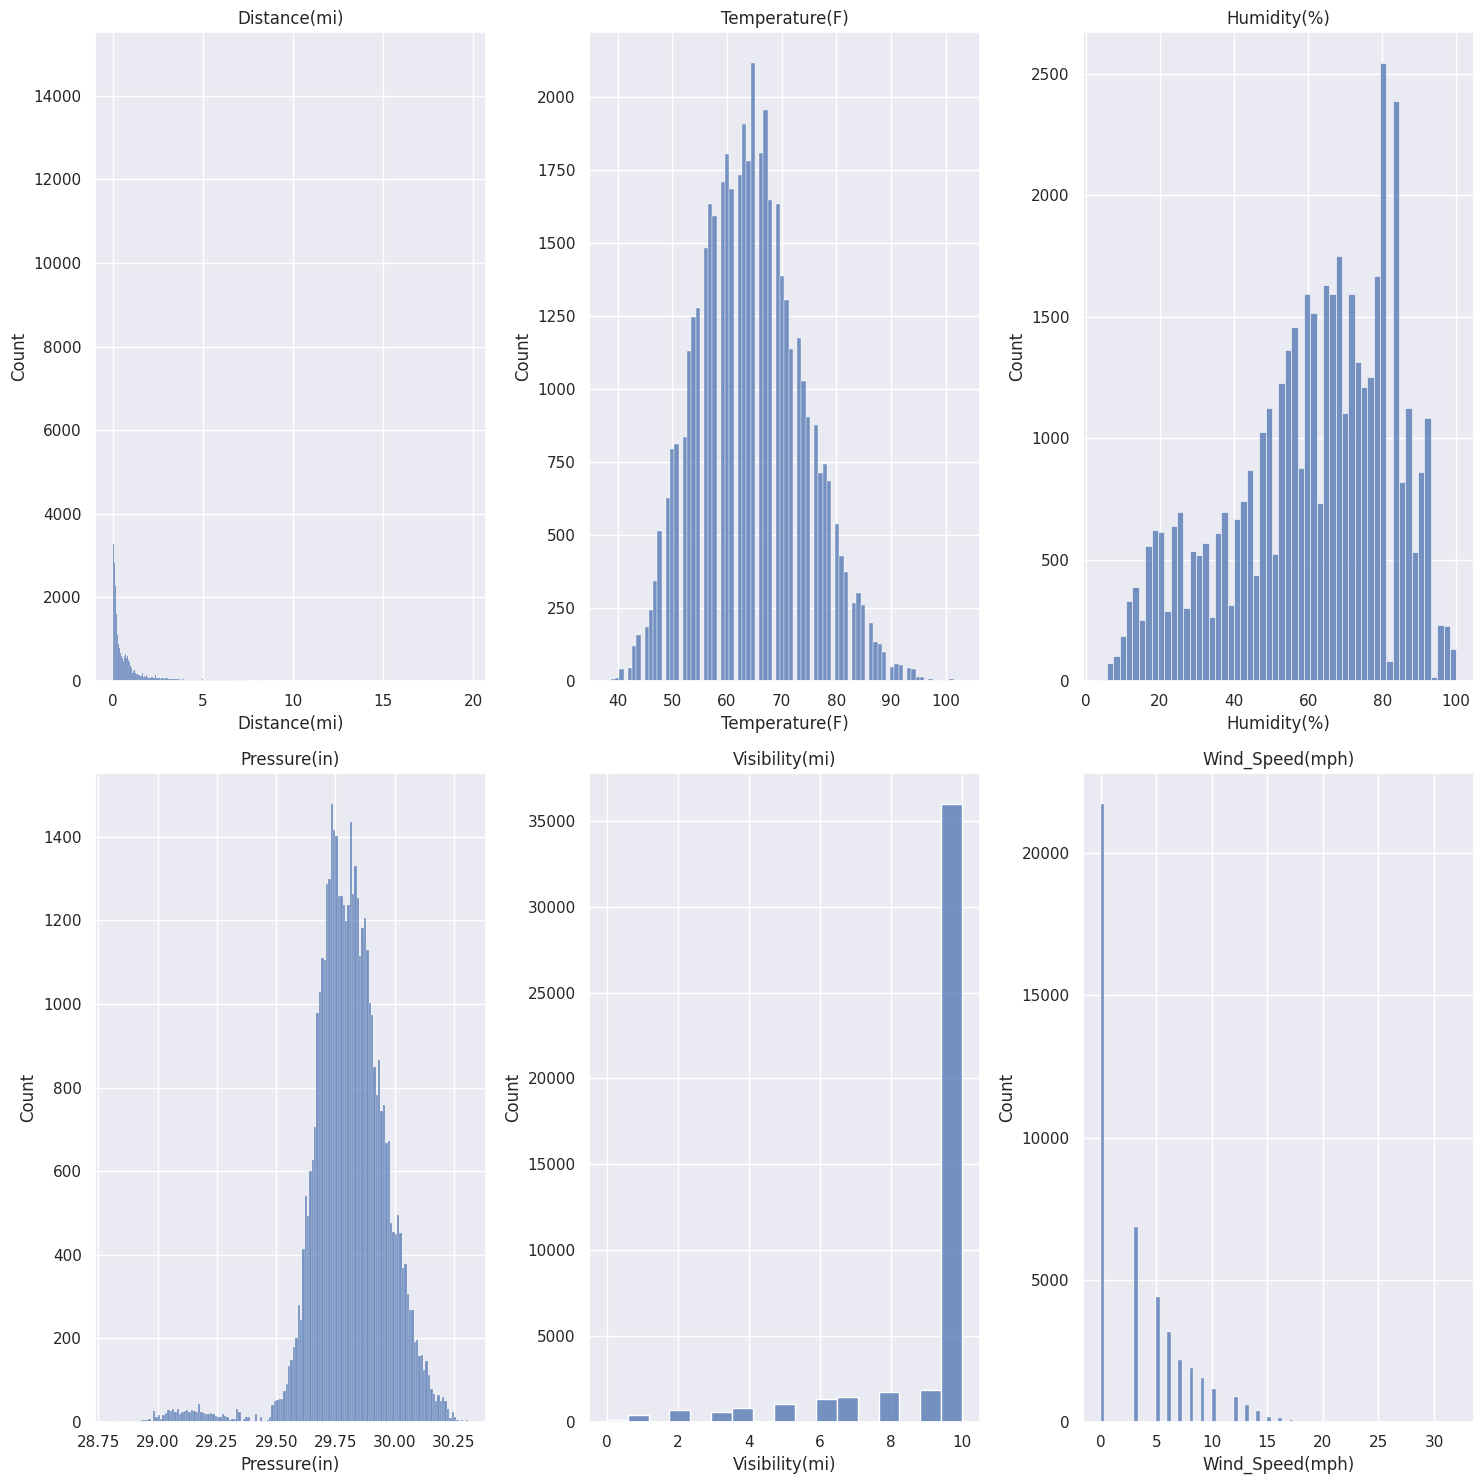

In [14]:
numerical_features = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
 
fig, axes = plt.subplots(2, 3, figsize = (15, 15), sharex = False, sharey = False)

count = 0
for col in numerical_features:
    x = count // 3
    y = count % 3
    sns.histplot(ax = axes[x, y], data = la, x = col)
    axes[x, y].set_title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

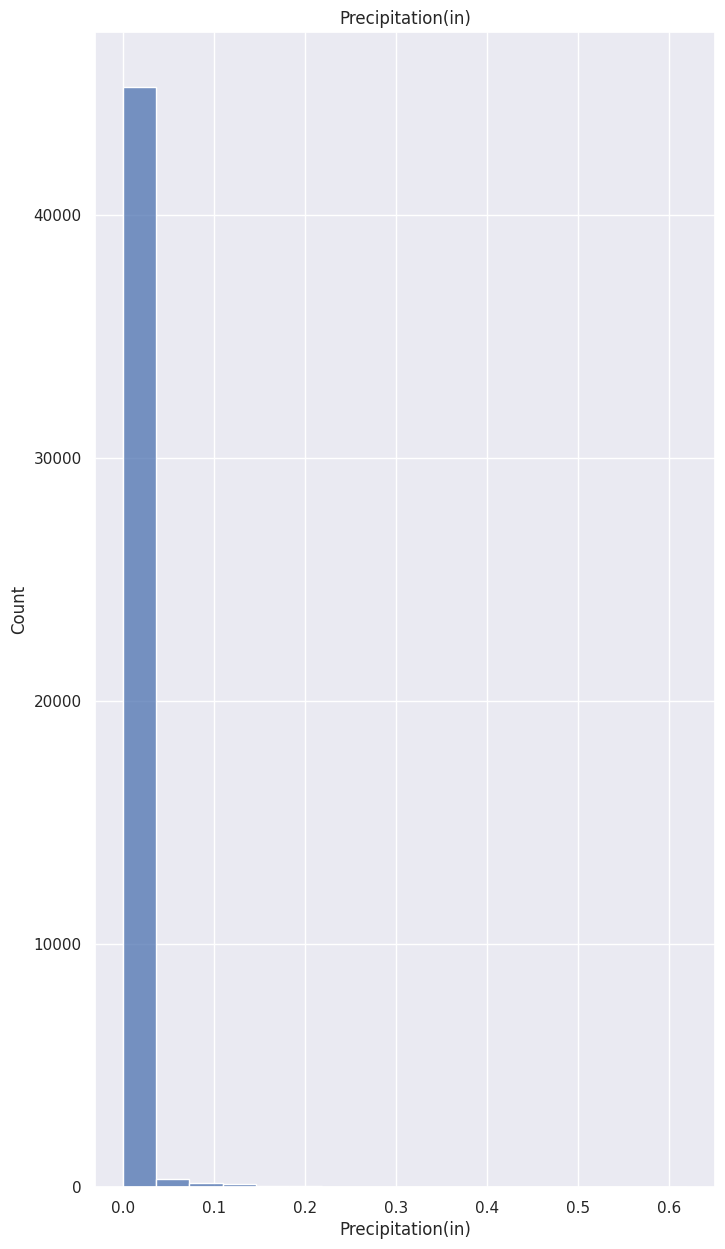

In [15]:
sns.histplot(data = la, x = 'Precipitation(in)')
plt.title('Precipitation(in)');

In [16]:
la.isnull().sum()

Severity               0
Start_Time             0
Start_Lat              0
Start_Lng              0
Distance(mi)           0
Temperature(F)       221
Wind_Chill(F)        920
Humidity(%)          253
Pressure(in)         216
Visibility(mi)        55
Wind_Direction       838
Wind_Speed(mph)      838
Precipitation(in)      4
Weather_Condition     35
Amenity                0
Bump                   0
Crossing               0
Give_Way               0
Junction               0
No_Exit                0
Railway                0
Roundabout             0
Station                0
Stop                   0
Traffic_Calming        0
Traffic_Signal         0
Sunrise_Sunset         0
Accident_Duration      0
dtype: int64

In [17]:
temp_mean = la['Temperature(F)'].mean()
wind_chill_mean = la['Wind_Chill(F)'].mean()
humid_mean = la['Humidity(%)'].mean()
pressure_mean = la['Pressure(in)'].mean()
visibility_mean = la['Visibility(mi)'].mean()
wind_mean = la['Wind_Speed(mph)'].mean()
precipitation_mean = la['Precipitation(in)'].mean()

la['Temperature(F)'] = la['Temperature(F)'].fillna(temp_mean)
la['Wind_Chill(F)'] = la['Wind_Chill(F)'].fillna(wind_chill_mean)
la['Humidity(%)'] = la['Humidity(%)'].fillna(humid_mean)
la['Pressure(in)'] = la['Pressure(in)'].fillna(pressure_mean)
la['Visibility(mi)'] = la['Visibility(mi)'].fillna(visibility_mean)
la['Wind_Speed(mph)'] = la['Wind_Speed(mph)'].fillna(wind_mean)
la['Precipitation(in)'] = la['Precipitation(in)'].fillna(precipitation_mean)

In [18]:
la.isnull().sum()

Severity               0
Start_Time             0
Start_Lat              0
Start_Lng              0
Distance(mi)           0
Temperature(F)         0
Wind_Chill(F)          0
Humidity(%)            0
Pressure(in)           0
Visibility(mi)         0
Wind_Direction       838
Wind_Speed(mph)        0
Precipitation(in)      0
Weather_Condition     35
Amenity                0
Bump                   0
Crossing               0
Give_Way               0
Junction               0
No_Exit                0
Railway                0
Roundabout             0
Station                0
Stop                   0
Traffic_Calming        0
Traffic_Signal         0
Sunrise_Sunset         0
Accident_Duration      0
dtype: int64

In [19]:
wind_direction_mode = la['Wind_Direction'].mode()[0]
weather_mode = la['Weather_Condition'].mode()[0]

la['Wind_Direction'] = la['Wind_Direction'].fillna(wind_direction_mode)
la['Weather_Condition'] = la['Weather_Condition'].fillna(weather_mode)

In [20]:
la.isnull().sum()

Severity             0
Start_Time           0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Sunrise_Sunset       0
Accident_Duration    0
dtype: int64

In [21]:
# Convert those weather condition that has less than 100 counts to other (group them together)
counts = la['Weather_Condition'].value_counts()
idx = counts[counts.lt(100)].index

la.loc[la['Weather_Condition'].isin(idx), 'Weather_Condition'] = 'Other'

la['Weather_Condition'].value_counts()

Weather_Condition
Fair             32826
Cloudy            6059
Mostly Cloudy     1993
Haze              1668
Partly Cloudy     1394
Light Rain        1172
Fog                453
Rain               322
Heavy Rain         143
Other               88
Name: count, dtype: int64

In [22]:
def to_datetime(row):
    time_format = "%Y-%m-%d %H:%M:%S"

    if len(row["Start_Time"]) == 19:
        dt = datetime.strptime(row["Start_Time"], time_format)
    
    elif len(row["Start_Time"]) == 26:
        dt = datetime.strptime(row["Start_Time"][:-7], time_format)
    
    elif len(row["Start_Time"]) == 29:
        dt = datetime.strptime(row["Start_Time"][:-10], time_format)
    
    return dt

# Get Day of Accident
la["Time_of_Incident"] = la.apply(lambda x: to_datetime(x), axis = 1)
la["Day"] = la.apply(lambda x: x.Time_of_Incident.day_name(), axis = 1)

# Get the decimal points of latitude and longtitude so it can be more sensitive to the model for location
la['Lat_Decimal'] = la.Start_Lat.astype(str).str.extract('\.(.*)').astype(int)
la['Lng_Decimal'] = la.Start_Lng.astype(str).str.extract('\.(.*)').astype(int)

la.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Accident_Duration,Time_of_Incident,Day,Lat_Decimal,Lng_Decimal
0,3,2022-09-08 12:46:45,33.987,-118.138,0.000,88.000,88.000,48.000,29.590,10.000,CALM,0.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,Day,1757.000,2022-09-08 12:46:45,Thursday,98748,137558
1,3,2022-09-08 09:15:12,33.929,-118.368,0.000,77.000,77.000,74.000,29.710,10.000,CALM,0.000,0.000,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,Day,1779.000,2022-09-08 09:15:12,Thursday,928959000000006,368271
2,1,2022-09-08 09:26:28,33.989,-118.256,0.000,79.000,79.000,60.000,29.670,9.000,VAR,3.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,True,Day,4520.000,2022-09-08 09:26:28,Thursday,989342,256462
3,1,2022-09-08 09:47:21,34.049,-118.270,0.000,79.000,79.000,60.000,29.670,9.000,VAR,3.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,Day,1771.000,2022-09-08 09:47:21,Thursday,4945,270073
4,2,2022-09-08 08:13:36,34.031,-118.218,0.000,75.000,75.000,76.000,29.670,10.000,CALM,0.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,Day,2671.000,2022-09-08 08:13:36,Thursday,30895,217926


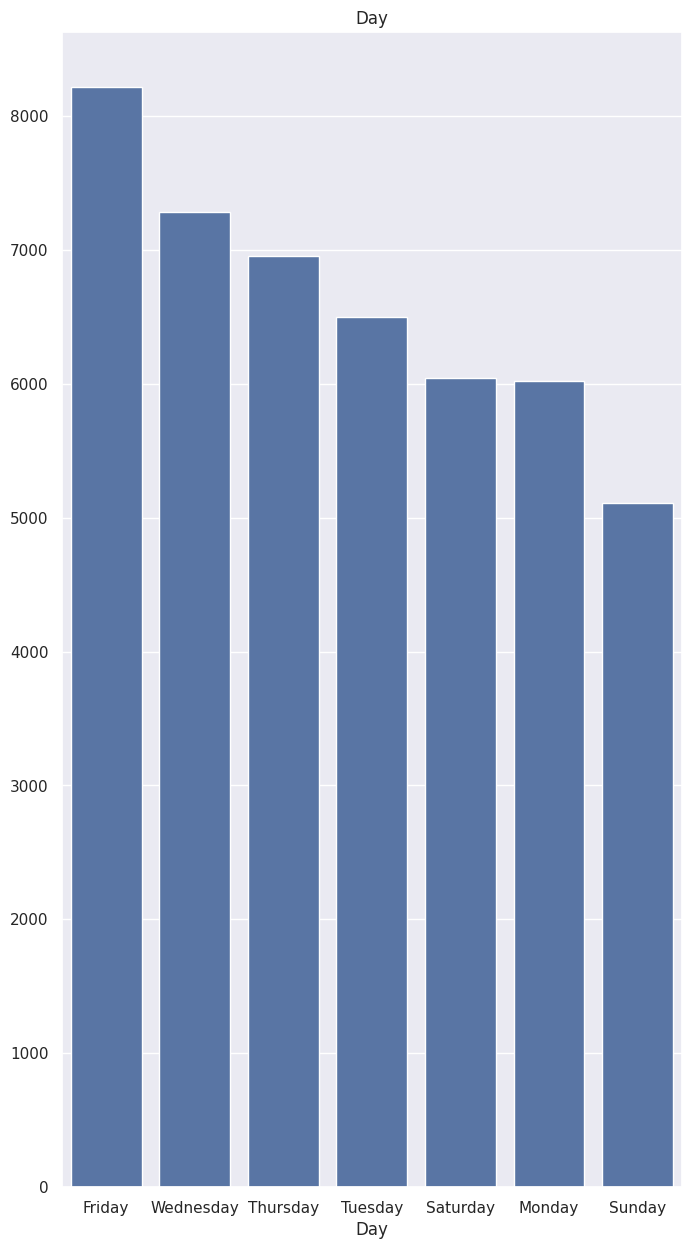

In [23]:
sns.barplot(x = la['Day'].value_counts().index, y = la['Day'].value_counts().values)
plt.title('Day');

In [24]:
# Converting Duration to categorys

# 15 mins or less = 0
# 15 - 30mins = 1
# 30 mins - 1hr = 2
# 1 - 3hr = 3
# 3hr - 6hr = 4
# rest of day = 5

la['ETA'] = 0
la.loc[la['Accident_Duration'] <= 900, 'ETA'] = 0 
la.loc[(la['Accident_Duration'] <= 1800) & (la['Accident_Duration'] > 900), 'ETA'] = 1
la.loc[(la['Accident_Duration'] <= 3600) & (la['Accident_Duration'] > 1800), 'ETA'] = 2
la.loc[(la['Accident_Duration'] <= 10800) & (la['Accident_Duration'] > 3600), 'ETA'] = 3
la.loc[(la['Accident_Duration'] <= 21600) & (la['Accident_Duration'] > 10800), 'ETA'] = 4
la.loc[la['Accident_Duration'] > 21600, 'ETA'] = 5

In [25]:
le = LabelEncoder()

la['Weather_Condition'] = le.fit_transform(la['Weather_Condition'])
la['Wind_Direction'] = le.fit_transform(la['Wind_Direction'])
la['Day'] = le.fit_transform(la['Day'])

cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Stop']

ohe = OneHotEncoder()
array_hot_encoded = ohe.fit_transform(la[cols]).toarray()
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = ohe.get_feature_names_out(), index=la.index)
data_other_cols = la.drop(columns = cols)
cleaned_la = pd.concat([data_hot_encoded, data_other_cols], axis=1)

cleaned_la.head()

,Amenity_False,Amenity_True,Bump_False,Bump_True,Crossing_False,Crossing_True,Give_Way_False,Give_Way_True,Junction_False,Junction_True,No_Exit_False,No_Exit_True,Railway_False,Railway_True,Roundabout_False,Roundabout_True,Station_False,Station_True,Traffic_Calming_False,Traffic_Calming_True,Traffic_Signal_False,Traffic_Signal_True,Sunrise_Sunset_Day,Sunrise_Sunset_Night,Stop_False,Stop_True,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Accident_Duration,Time_of_Incident,Day,Lat_Decimal,Lng_Decimal,ETA
0,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,3,2022-09-08 12:46:45,33.987,-118.138,0.000,88.000,88.000,48.000,29.590,10.000,0,0.000,0.000,1,1757.000,2022-09-08 12:46:45,4,98748,137558,1
1,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,3,2022-09-08 09:15:12,33.929,-118.368,0.000,77.000,77.000,74.000,29.710,10.000,0,0.000,0.000,6,1779.000,2022-09-08 09:15:12,4,928959000000006,368271,1
2,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,1,2022-09-08 09:26:28,33.989,-118.256,0.000,79.000,79.000,60.000,29.670,9.000,14,3.000,0.000,1,4520.000,2022-09-08 09:26:28,4,989342,256462,3
3,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1,2022-09-08 09:47:21,34.049,-118.270,0.000,79.000,79.000,60.000,29.670,9.000,14,3.000,0.000,1,1771.000,2022-09-08 09:47:21,4,4945,270073,1
4,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,2,2022-09-08 08:13:36,34.031,-118.218,0.000,75.000,75.000,76.000,29.670,10.000,0,0.000,0.000,1,2671.000,2022-09-08 08:13:36,4,30895,217926,2


In [26]:
y = cleaned_la['Accident_Duration']
X = cleaned_la.drop(['Accident_Duration', 'Start_Time', 'Time_of_Incident', 'ETA'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [27]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [28]:
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

compare_regression = pd.DataFrame(y_test)
compare_regression.rename(columns = {'Accident_Duration' : 'Actual'}, inplace = True)
compare_regression['Predicted'] = y_pred
compare_regression['80% Actual'] = 0.8 * compare_regression['Actual']
compare_regression['120% Actual'] = 1.2 * compare_regression['Actual']
compare_regression['Good_Prediction'] = compare_regression['Predicted'].between(compare_regression['80% Actual'], compare_regression['120% Actual'])
compare_regression['Good_Prediction'].value_counts()

Mean Absolute Error: 7610.179539044213
Mean Squared Error: 254494888.0239072
Root Mean Squared Error: 15952.895913404162


Good_Prediction
False    11910
True      1926
Name: count, dtype: int64

In [29]:
clf = MLPRegressor(hidden_layer_sizes = (10), solver = 'lbfgs', max_iter = 10000, random_state = 42)
clf.fit(X_train, y_train)

y_pred_mlp = clf.predict(X_test)

print("Train:", clf.score(X_train, y_train))
print("Test:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred_mlp))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))

compare_mlp = pd.DataFrame(y_test)
compare_mlp.rename(columns = {'Accident_Duration' : 'Actual'}, inplace = True)
compare_mlp['Predicted'] = y_pred_mlp
compare_mlp['80% Actual'] = 0.8 * compare_mlp['Actual']
compare_mlp['120% Actual'] = 1.2 * compare_mlp['Actual']
compare_mlp['Good_Prediction'] = compare_mlp['Predicted'].between(compare_mlp['80% Actual'], compare_mlp['120% Actual'])
compare_mlp['Good_Prediction'].value_counts()

Train: -0.35299352377776727
Test: -0.3234311617677026
MSE: 336911156.3753179
RMSE: 18355.13978087113


Good_Prediction
False    13548
True       288
Name: count, dtype: int64

In [30]:
# Attemping Classifier as we don't need to know the exact time it will take to clear the accident, but generally a sense of it (binned duration to relevant categories)
y = cleaned_la['ETA']
X = cleaned_la.drop(['Accident_Duration', 'Start_Time', 'Time_of_Incident', 'ETA'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [31]:
mlp_class = MLPClassifier(hidden_layer_sizes = (10), activation = 'logistic', solver = 'lbfgs', max_iter = 10000, random_state = 42)

mlp_class.fit(X_train, y_train)

y_pred_test = mlp_class.predict(X_test)
print(accuracy_score(y_test, y_pred_test))

0.4889418907198612


In [32]:
# Depth 3
features = X
records = features.to_dict('records')
label = la['ETA']

vec = DictVectorizer()
feature_data = vec.fit_transform(records).toarray()

d_tree = DecisionTreeClassifier(max_depth = 3, random_state = 42)
d_tree = d_tree.fit(feature_data, label)
print(d_tree.score(feature_data, label))

0.5637061451060323


In [33]:
# Depth 5
d_tree = DecisionTreeClassifier(max_depth = 5, random_state = 42)
d_tree = d_tree.fit(feature_data, label)
print(d_tree.score(feature_data, label))

0.5720109284877922


In [34]:
# Depth 10
d_tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
d_tree = d_tree.fit(feature_data, label)
print(d_tree.score(feature_data, label))

0.6261329632681383


In [35]:
clf_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf_forest.fit(X_train, y_train)

y_pred_forest = clf_forest.predict(X_test)
print(accuracy_score(y_test, y_pred_forest))

0.6129661751951431


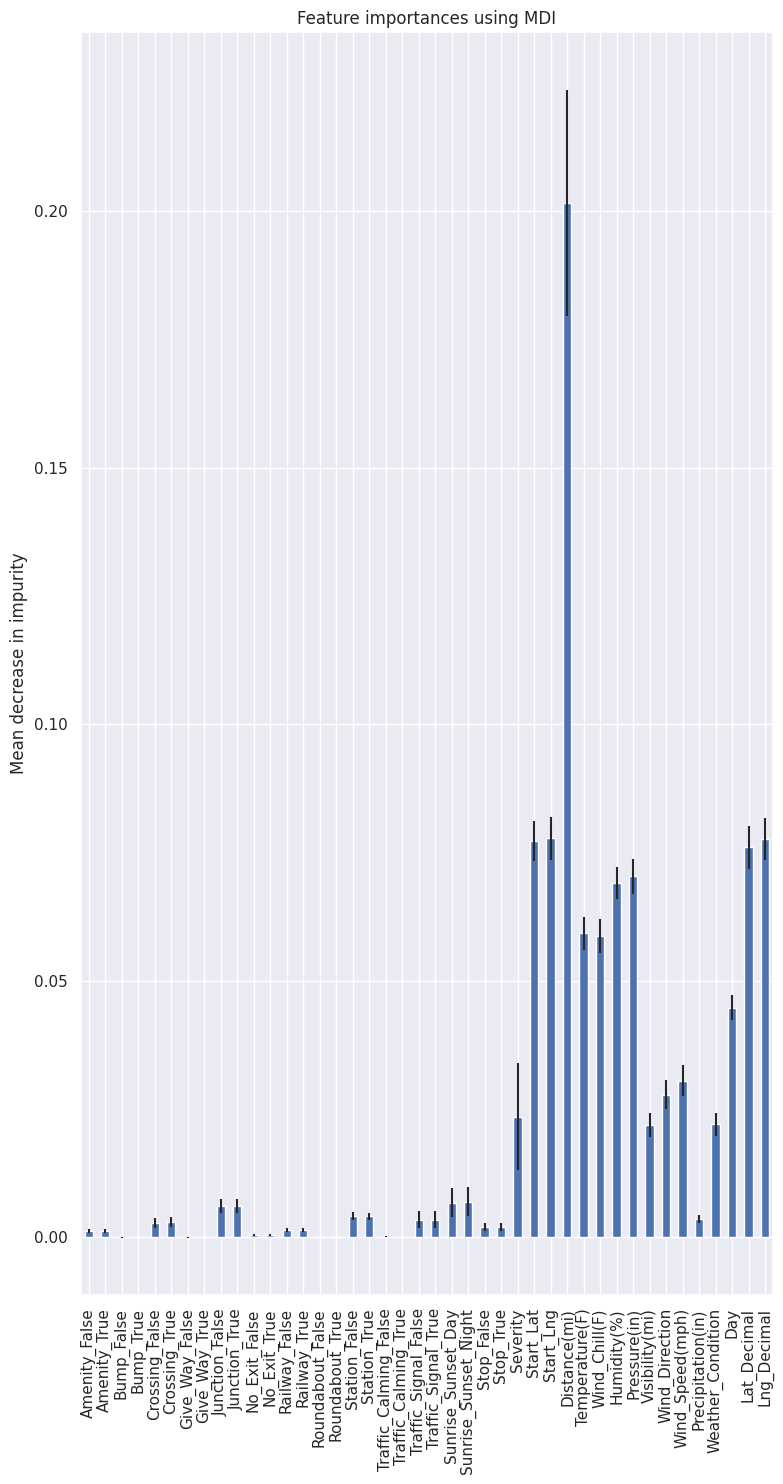

In [36]:
importances = clf_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index = X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [37]:
# After removing less important features
y = cleaned_la['ETA']
X = cleaned_la[['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Day', 'Lat_Decimal', 'Lng_Decimal']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [38]:
clf_forest_2 = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf_forest_2.fit(X_train, y_train)

y_pred_forest_2 = clf_forest_2.predict(X_test)
print(accuracy_score(y_test, y_pred_forest_2))

0.6139057531078347


In [39]:
mlp_class_2 = MLPClassifier(hidden_layer_sizes = (10), activation = 'logistic', solver = 'lbfgs', max_iter = 10000, random_state = 42)

mlp_class_2.fit(X_train, y_train)

y_pred_test_2 = mlp_class_2.predict(X_test)
print(accuracy_score(y_test, y_pred_test_2))

0.4889418907198612


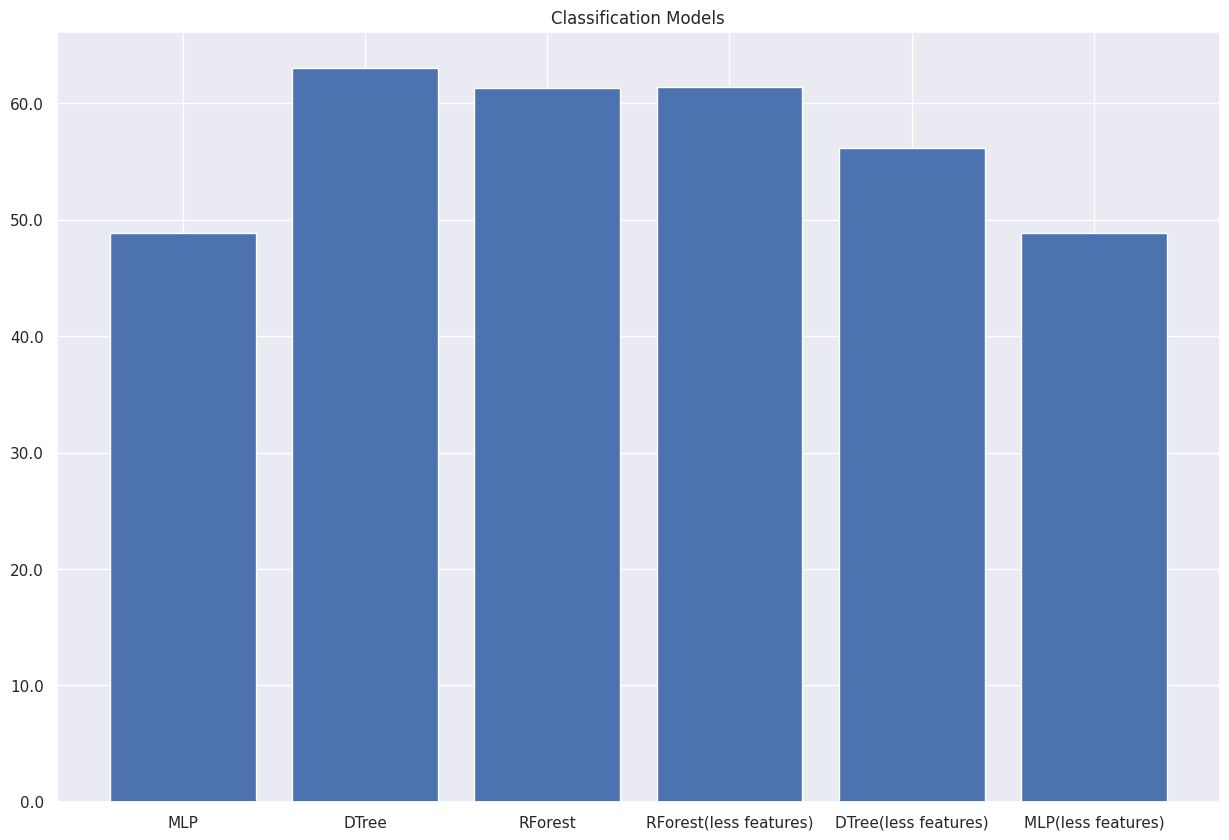

In [40]:
x = np.arange(6)
accuracy = [48.9, 63.0, 61.3, 61.4, 56.2, 48.9]

def millions(x, pos):
    'The two args are the value and tick position'
    return (x )

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize = (15, 10))
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, accuracy)
plt.xticks(x, ('MLP', 'DTree', 'RForest', 'RForest(less features)', 'DTree(less features)', 'MLP(less features)'))
plt.title('Classification Models')
plt.show()

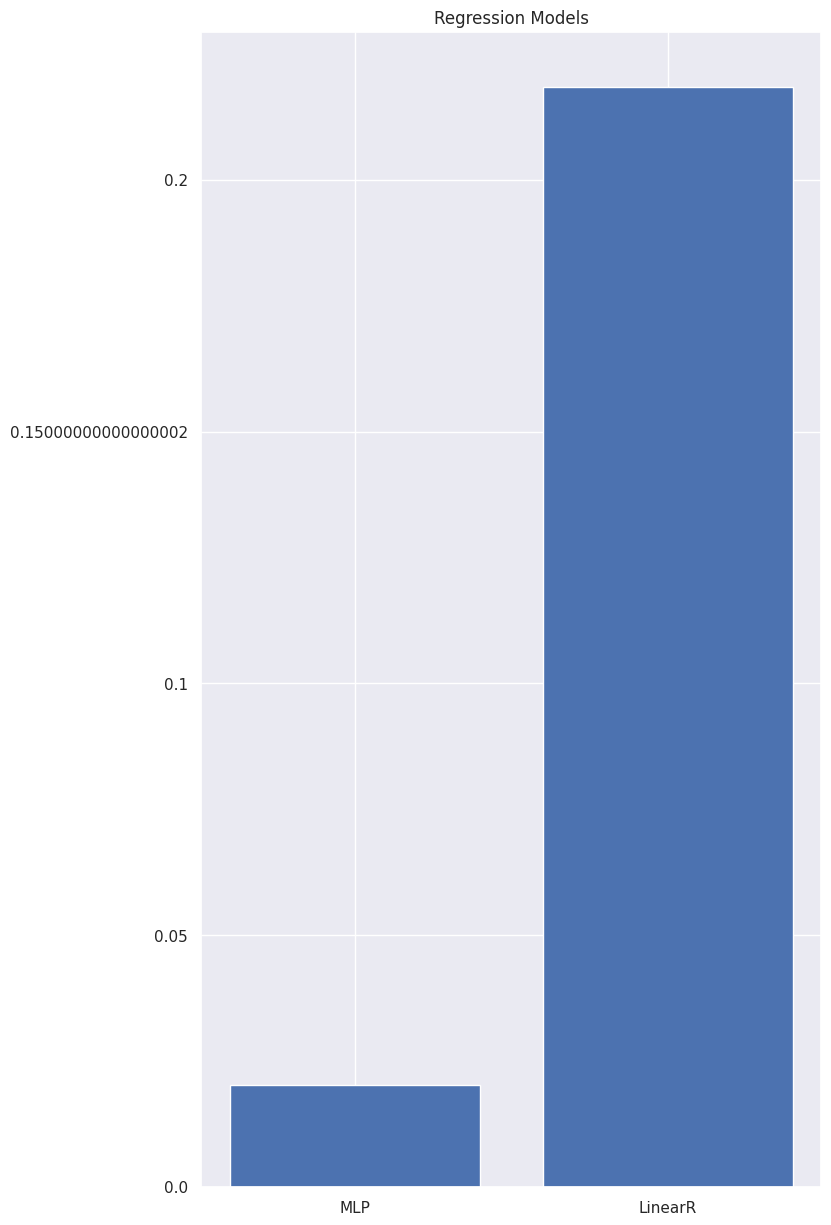

In [41]:
x = np.arange(2)
accuracy = [279 / 13836, 3023 / 13836]

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, accuracy)
plt.xticks(x, ('MLP', 'LinearR'))
plt.title('Regression Models')
plt.show()

# Charlotte

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
charlotte = pd.read_csv('Charlotte_accidents.csv')

In [43]:
df = charlotte.copy()

In [44]:
#drop 
df = df.drop(columns=['Wind_Direction', 'Start_Lat', 'Start_Lng', 'End_Time','Weather_Timestamp', 'End_Lat', 'End_Lng', 'City', 'State', 'Street', 'Country', 'Timezone', 
                      'Airport_Code', 'Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight', 'Accident_Duration_Hours', 'Accident_Duration_Minutes', 'Accident_Duration_Seconds'])

In [45]:
df = df.dropna()

In [46]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Start_Time'] = df['Start_Time'].dt.hour

In [47]:
# List of keywords to check for
keywords = ['blocked', 'delays', 'I-', 'NC-', 'ST']

for keyword in keywords:
    df[keyword.lower()] = df['Description'].str.contains(keyword, case=False)
df

,ID,Source,Severity,Start_Time,Distance(mi),Description,County,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Civil_Twilight,Accident_Duration,blocked,delays,i-,nc-,st
0,A-512254,Source2,1,6,0.000,Lane blocked due to crash on Quality Dr at Wes...,Mecklenburg,28278-8737,70.000,70.000,81.000,29.170,10.000,9.000,0.000,Cloudy,False,False,True,False,False,False,False,False,False,False,False,False,False,Night,4671.000,True,False,False,False,True
1,A-512255,Source2,1,6,0.000,Lane blocked due to crash on Pheasant Chase Ln...,Mecklenburg,28216-3294,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,4464.000,True,False,False,False,False
2,A-512256,Source2,1,6,0.000,Crash on NC-16 Brookshire Blvd at Mt Holly-Hun...,Mecklenburg,28214,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,False,False,True,False,False,False,False,False,False,False,False,True,False,Night,3529.000,False,False,False,True,False
3,A-512285,Source2,1,6,0.000,Crash on Mt Holly-Huntersville Rd at Chastain ...,Mecklenburg,28216-7662,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,1745.000,False,False,False,False,True
4,A-512332,Source2,1,5,0.000,Crash on Tuckaseegee Rd at Jay St.,Mecklenburg,28208,70.000,70.000,81.000,29.090,10.000,9.000,0.000,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,1902.000,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39145,A-6940750,Source1,2,3,0.056,Incident on N TRYON ST near ORR RD Expect delays.,Mecklenburg,28213,52.000,52.000,100.000,29.510,2.000,0.000,0.000,Fog,False,False,True,False,False,False,True,False,False,False,False,True,False,Night,8896.000,False,True,False,False,True
39146,A-6942034,Source1,2,6,0.089,Incident on E 5TH ST near N TRYON ST Expect de...,Mecklenburg,28202-2136,54.000,54.000,97.000,29.420,0.750,12.000,0.030,Light Rain,True,False,True,False,False,False,False,False,False,False,False,False,False,Night,7372.000,False,True,False,False,True
39147,A-6942832,Source1,2,2,0.010,Incident on ASHLEY RD near FREEDOM DR Drive wi...,Mecklenburg,28208-2819,53.000,53.000,100.000,29.430,0.250,7.000,0.000,Fog,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,7946.000,False,False,False,False,False
39148,A-6951033,Source1,2,2,0.625,Incident on I-77 near W ARROWOOD RD Expect del...,Mecklenburg,28273,53.000,53.000,100.000,29.410,0.250,10.000,0.000,Fog,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,4726.000,False,True,True,False,False


In [48]:
# Trimming
trim_percentage = 5

# Identify the lower and upper quantiles for trimming
lower_quantile = trim_percentage / 100
upper_quantile = 1 - (trim_percentage / 100)

numeric_columns = df.select_dtypes(include='number')
row_mask = (numeric_columns >= numeric_columns.quantile(lower_quantile)) & (numeric_columns <= numeric_columns.quantile(upper_quantile))
row_mask = row_mask.all(axis=1)

df = df[row_mask]
df

,ID,Source,Severity,Start_Time,Distance(mi),Description,County,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Civil_Twilight,Accident_Duration,blocked,delays,i-,nc-,st
0,A-512254,Source2,1,6,0.000,Lane blocked due to crash on Quality Dr at Wes...,Mecklenburg,28278-8737,70.000,70.000,81.000,29.170,10.000,9.000,0.000,Cloudy,False,False,True,False,False,False,False,False,False,False,False,False,False,Night,4671.000,True,False,False,False,True
1,A-512255,Source2,1,6,0.000,Lane blocked due to crash on Pheasant Chase Ln...,Mecklenburg,28216-3294,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,4464.000,True,False,False,False,False
2,A-512256,Source2,1,6,0.000,Crash on NC-16 Brookshire Blvd at Mt Holly-Hun...,Mecklenburg,28214,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,False,False,True,False,False,False,False,False,False,False,False,True,False,Night,3529.000,False,False,False,True,False
3,A-512285,Source2,1,6,0.000,Crash on Mt Holly-Huntersville Rd at Chastain ...,Mecklenburg,28216-7662,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,1745.000,False,False,False,False,True
4,A-512332,Source2,1,5,0.000,Crash on Tuckaseegee Rd at Jay St.,Mecklenburg,28208,70.000,70.000,81.000,29.090,10.000,9.000,0.000,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,1902.000,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39095,A-6569235,Source1,2,9,0.023,Incident on PARK RD near SENECA PL Drive with ...,Mecklenburg,28209-3274,40.000,34.000,43.000,29.530,10.000,8.000,0.000,Fair,False,False,True,False,False,False,False,False,False,False,False,True,False,Day,11174.000,False,False,False,False,False
39102,A-6569515,Source1,2,6,0.202,Incident on OAKDALE RD near KELLY RD Drive wit...,Mecklenburg,28216-1482,37.000,33.000,93.000,29.120,4.000,5.000,0.000,Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,6073.000,False,False,False,False,False
39105,A-6569846,Source1,2,18,0.142,Incident on RUNNYMEDE LN near WINDSOR DR Drive...,Mecklenburg,28209,46.000,46.000,61.000,29.200,10.000,3.000,0.000,Fair,False,False,True,False,False,False,False,False,False,True,False,False,False,Night,9661.000,False,False,False,False,False
39107,A-6570617,Source1,2,13,0.026,Incident on N SARDIS RD near GALLERIA VILLAGE ...,Mecklenburg,28270-2402,67.000,67.000,42.000,29.390,10.000,6.000,0.000,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,8487.000,False,False,False,False,False


In [49]:
boolean_columns = df.select_dtypes(include='bool').columns
df[boolean_columns] = df[boolean_columns].astype(int)
df

,ID,Source,Severity,Start_Time,Distance(mi),Description,County,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Civil_Twilight,Accident_Duration,blocked,delays,i-,nc-,st
0,A-512254,Source2,1,6,0.000,Lane blocked due to crash on Quality Dr at Wes...,Mecklenburg,28278-8737,70.000,70.000,81.000,29.170,10.000,9.000,0.000,Cloudy,0,0,1,0,0,0,0,0,0,0,0,0,0,Night,4671.000,1,0,0,0,1
1,A-512255,Source2,1,6,0.000,Lane blocked due to crash on Pheasant Chase Ln...,Mecklenburg,28216-3294,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,4464.000,1,0,0,0,0
2,A-512256,Source2,1,6,0.000,Crash on NC-16 Brookshire Blvd at Mt Holly-Hun...,Mecklenburg,28214,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,0,0,1,0,0,0,0,0,0,0,0,1,0,Night,3529.000,0,0,0,1,0
3,A-512285,Source2,1,6,0.000,Crash on Mt Holly-Huntersville Rd at Chastain ...,Mecklenburg,28216-7662,69.000,69.000,84.000,29.090,10.000,8.000,0.000,Mostly Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Day,1745.000,0,0,0,0,1
4,A-512332,Source2,1,5,0.000,Crash on Tuckaseegee Rd at Jay St.,Mecklenburg,28208,70.000,70.000,81.000,29.090,10.000,9.000,0.000,Partly Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,1902.000,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39095,A-6569235,Source1,2,9,0.023,Incident on PARK RD near SENECA PL Drive with ...,Mecklenburg,28209-3274,40.000,34.000,43.000,29.530,10.000,8.000,0.000,Fair,0,0,1,0,0,0,0,0,0,0,0,1,0,Day,11174.000,0,0,0,0,0
39102,A-6569515,Source1,2,6,0.202,Incident on OAKDALE RD near KELLY RD Drive wit...,Mecklenburg,28216-1482,37.000,33.000,93.000,29.120,4.000,5.000,0.000,Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,6073.000,0,0,0,0,0
39105,A-6569846,Source1,2,18,0.142,Incident on RUNNYMEDE LN near WINDSOR DR Drive...,Mecklenburg,28209,46.000,46.000,61.000,29.200,10.000,3.000,0.000,Fair,0,0,1,0,0,0,0,0,0,1,0,0,0,Night,9661.000,0,0,0,0,0
39107,A-6570617,Source1,2,13,0.026,Incident on N SARDIS RD near GALLERIA VILLAGE ...,Mecklenburg,28270-2402,67.000,67.000,42.000,29.390,10.000,6.000,0.000,Mostly Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Day,8487.000,0,0,0,0,0


In [50]:
target_column = 'Accident_Duration'
numeric_columns = df.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()
correlations = correlation_matrix[target_column].drop(target_column)
sorted_features = correlations.abs().sort_values(ascending=False)
print(sorted_features)

blocked             0.254
Distance(mi)        0.242
Traffic_Signal      0.223
Severity            0.222
delays              0.146
Humidity(%)         0.097
Start_Time          0.067
Crossing            0.066
Wind_Speed(mph)     0.060
i-                  0.049
st                  0.043
nc-                 0.040
Railway             0.039
Give_Way            0.026
No_Exit             0.017
Wind_Chill(F)       0.014
Visibility(mi)      0.014
Temperature(F)      0.014
Stop                0.011
Bump                0.008
Amenity             0.008
Station             0.008
Traffic_Calming     0.007
Junction            0.006
Pressure(in)        0.006
Precipitation(in)   0.004
Roundabout            NaN
Turning_Loop          NaN
Name: Accident_Duration, dtype: float64


In [51]:
from sklearn.ensemble import RandomForestRegressor

a = df.drop(columns=['ID', 'Description', 'Zipcode'])

categorical_columns = a.select_dtypes(include=['object']).columns

# Select only categorical columns
X_categorical = a[categorical_columns]

X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)
X_combined = pd.concat([a.drop(categorical_columns, axis=1), X_categorical_encoded], axis=1)

# Split the data into features and target
X = X_combined.drop('Accident_Duration', axis=1)  # Updated target column
y = X_combined['Accident_Duration']

# Use RandomForestRegressor for feature importance
rf = RandomForestRegressor()
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
selected_features_rf = feature_importances[feature_importances > 0.05].index
selected_features_rf

Index(['Start_Time', 'Distance(mi)', 'Humidity(%)', 'Pressure(in)',
       'Wind_Speed(mph)'],
      dtype='object')

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def within_percentage(y_true, y_pred, percentage=10):
    lower_bound = (100 - percentage) / 100.0 * y_true
    upper_bound = (100 + percentage) / 100.0 * y_true
    within_range = np.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)
    return within_range.mean()

target_column = 'Accident_Duration'
selected_features = ['Junction', 'blocked', 'Distance(mi)', 'Temperature(F)', 'Traffic_Signal', 
'delays', 'Start_Time', 'Humidity(%)', 'Pressure(in)', 'Crossing', 'Wind_Speed(mph)']

y = df[target_column]
X = df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

accuracy_within_10_percent = within_percentage(y_test, y_pred, percentage=10)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Accuracy within 10%: {accuracy_within_10_percent}')

Mean Squared Error: 3356426.200666482
R-squared: 0.48534170452023784
Accuracy within 10%: 0.32243794544114035


In [53]:
from sklearn.linear_model import LinearRegression

target_column = 'Accident_Duration'
selected_features = ['Junction', 'blocked', 'Distance(mi)', 'Temperature(F)', 'Traffic_Signal', 'delays', 
'Start_Time', 'Humidity(%)', 'Pressure(in)', 'Crossing', 'Wind_Speed(mph)']

y = df[target_column]
X = df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

accuracy_within_10_percent = within_percentage(y_test, y_pred, percentage=10)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Accuracy within 10%: {accuracy_within_10_percent}')

Mean Squared Error: 5607207.1214612005
R-squared: 0.14021775334724296
Accuracy within 10%: 0.12632096338166626


# Houston

In [54]:
import numpy as np 
import pandas as pd
df = pd.read_csv("Houston_accidents.csv")
df = df[df.State == "TX"]
df = df.drop(columns=[
    'ID',                             
    'Source', 
    'Description',    
    'End_Time',  
    'Street',    
    'City',    
    'County',    
    'State',     
    'Country',    
    'Timezone',
    "Weather_Condition",
    "Wind_Direction",
])

In [55]:
# Additional Feature Engineering
import datetime as dt
df["Start_Time"] = pd.to_datetime(df["Start_Time"])
df["Start_Time"] = df["Start_Time"].map(dt.datetime.toordinal)
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])
df['Weather_Timestamp'] = df['Weather_Timestamp'].map(dt.datetime.toordinal)
df["Zipcode"] = df["Zipcode"].str[:5]

# One Hot Encoding
one_hot_cols = [
    "Sunrise_Sunset",
    "Civil_Twilight",
    "Nautical_Twilight",
    "Astronomical_Twilight",
    "Airport_Code"
]
for _ in one_hot_cols:
    df = pd.get_dummies(df, columns=[_])
df = df.dropna()
pd.set_option('display.max_columns', None)
df

,Severity,Start_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Accident_Duration,Accident_Duration_Hours,Accident_Duration_Minutes,Accident_Duration_Seconds,Sunrise_Sunset_Day,Sunrise_Sunset_Night,Civil_Twilight_Day,Civil_Twilight_Night,Nautical_Twilight_Day,Nautical_Twilight_Night,Astronomical_Twilight_Day,Astronomical_Twilight_Night,Airport_Code_KAXH,Airport_Code_KDWH,Airport_Code_KEFD,Airport_Code_KHOU,Airport_Code_KIAH,Airport_Code_KMCJ,Airport_Code_KSGR,Airport_Code_KTME
17561,2,738401,29.725,-95.298,29.723,-95.298,0.147,77023,738401,84.000,84.000,79.000,30.010,8.000,0.000,0.000,False,False,True,False,False,False,False,False,False,True,False,False,False,5760.000,1,36,0,True,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False
17562,2,738378,29.742,-95.498,29.741,-95.497,0.119,77057,738378,86.000,86.000,65.000,29.890,10.000,10.000,0.000,False,False,False,False,False,False,False,False,False,False,False,False,False,4501.000,1,15,1,False,True,False,True,True,False,True,False,False,False,False,False,False,True,False,False
17563,2,738549,29.737,-95.521,29.737,-95.521,0.011,77063,738549,71.000,71.000,93.000,29.950,8.000,15.000,0.000,False,False,True,False,False,False,False,False,False,False,False,True,False,4501.000,1,15,1,True,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False
17564,2,738496,29.735,-95.521,29.735,-95.521,0.018,77063,738496,78.000,78.000,71.000,30.110,10.000,13.000,0.000,False,False,False,False,False,False,False,False,False,False,False,False,False,4500.000,1,15,0,True,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False
17565,2,738431,29.679,-95.453,29.690,-95.459,0.820,77096,738431,87.000,87.000,22.000,29.980,10.000,9.000,0.000,False,False,False,False,False,False,False,False,False,False,False,False,False,8551.000,2,22,31,True,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42430,2,737791,29.729,-95.359,29.728,-95.358,0.071,77004,737791,41.000,35.000,73.000,29.850,10.000,10.000,0.000,False,False,False,False,False,False,False,False,False,False,False,False,False,15840.000,4,24,0,False,True,False,True,False,True,False,True,False,False,False,False,False,True,False,False
42431,2,737791,29.726,-95.466,29.730,-95.455,0.709,77056,737791,43.000,37.000,76.000,29.780,10.000,12.000,0.000,False,False,False,False,False,False,False,False,False,False,False,False,False,4500.000,1,15,0,False,True,False,True,False,True,False,True,False,False,False,False,False,True,False,False
42432,2,737791,29.975,-95.421,30.012,-95.428,2.601,77090,737791,40.000,33.000,73.000,29.680,10.000,13.000,0.000,False,False,False,False,True,False,False,False,False,False,False,False,False,3153.000,0,52,33,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,False
42433,2,737791,29.846,-95.378,29.846,-95.378,0.003,77022,737791,43.000,37.000,76.000,29.780,10.000,12.000,0.000,True,False,True,True,False,False,False,False,False,False,False,True,False,4500.000,1,15,0,False,True,False,True,False,True,False,True,False,False,False,False,False,True,False,False


In [56]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=[  
    'Accident_Duration',  
    'Accident_Duration_Hours',   
    'Accident_Duration_Minutes',    
    'Accident_Duration_Seconds'
])
y = np.ravel(df[['Accident_Duration']])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [57]:
from sklearn.tree import DecisionTreeClassifier
best_dt = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=40, 
    max_features='log2', 
    min_samples_leaf=12, 
    min_samples_split=7
)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=40, max_features='log2',
                       min_samples_leaf=12, min_samples_split=7)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
best_rf = RandomForestClassifier(
    max_depth=30, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=13, 
    n_estimators=67
)
best_rf.fit(X_train, y_train)

In [ ]:
from sklearn.neural_network import MLPClassifier
best_mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='tanh',                 
    solver='adam'
)
best_mlp.fit(X_train, y_train)

In [ ]:
print("DT Test Set Score:", best_dt.score(X_test, y_test))
print("RF Test Set Score:", best_rf.score(X_test, y_test))
print("MLP Test Set Score:", best_mlp.score(X_test, y_test))

In [ ]:
def margin_accuracy(y_true, y_pred, margin):
    correct_predictions = np.abs(y_true - y_pred) / y_pred <= margin
    accuracy = np.sum(correct_predictions) / len(y_true)
    return accuracy
margin = 0.2
print(f"DT Accuracy within {margin*100}% margin of error:", margin_accuracy(y_test, best_dt.predict(X_test), margin))
print(f"RF Accuracy within {margin*100}% margin of error:", margin_accuracy(y_test, best_rf.predict(X_test), margin))
print(f"MLP Accuracy within {margin*100}% margin of error:", margin_accuracy(y_test, best_mlp.predict(X_test), margin))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(5, 4)})
sns.countplot(x='Severity', data=df, palette="Set3")
plt.yscale('log')

In [ ]:
sns.set(rc = {'figure.figsize':(10, 20)})
sns.pairplot(df[[
    'Distance(mi)',
    'Temperature(F)',
    'Humidity(%)',
    'Pressure(in)',
    'Visibility(mi)',
    'Wind_Speed(mph)',
    'Precipitation(in)',
    'Accident_Duration'
]], size = 2)

# Miami

In [ ]:
!pip install xgboost
import numpy as np 
import pandas as pd
from scipy.stats import zscore
import re
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


In [ ]:
# exploring data
miami_df = pd.read_csv("Miami_accidents.csv")
miami_df.head(5)
miami_df.shape
miami_df.describe()
miami_df.info()
miami_df.isna().sum()
clean = miami_df[(np.floor(miami_df["Start_Lat"]) == 25) & (np.floor(miami_df["Start_Lng"]) == -81)].dropna()


In [ ]:
# numeric features
clean["S_Lat"] = clean["Start_Lat"]%1
clean["S_Lng"] = clean["Start_Lng"]%1 
clean["E_Lat"] = clean["End_Lat"]%1 
clean["E_Lng"] = clean["End_Lng"]%1 
numeric_df = clean.select_dtypes(include = "number")
numeric_df = numeric_df.drop(columns = ['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Accident_Duration_Hours',
       'Accident_Duration_Minutes', 'Accident_Duration_Seconds'])
columns_to_scale = ['S_Lat', 'S_Lng', 'E_Lat', 'E_Lng']
scaler = MinMaxScaler()
z_scores = zscore(numeric_df)
numeric_df[columns_to_scale] = scaler.fit_transform(numeric_df[columns_to_scale])
numeric_df = numeric_df.mask(np.abs(z_scores) > 3, np.sign(z_scores)*3 )
correlations = np.abs(numeric_df.corr()["Accident_Duration"]).sort_values(ascending=False)[:10]
print(correlations)


In [ ]:
#Lasso for numeric features
X = numeric_df.drop('Accident_Duration', axis=1)
y = numeric_df['Accident_Duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso_model = Lasso()

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")
best_lasso_model = grid_search.best_estimator_

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_lasso_model.coef_})
print("\nCoefficients for the Best Model:")
coefficients["is_zero"] = coefficients["Coefficient"]==0
print(coefficients)


In [ ]:
# categorical features
categorical_df = clean.select_dtypes(include = "object")
categorical_df["Description"]  = categorical_df["Description"].str.lower()
categorical_df["Street"]  = categorical_df["Street"].str.lower()
def categorize_street(street):
    if re.match(r'(i-\d{2,3}|hwy|expy|fwy|fl\d{1,2})', street):
        return "Highway/Interstate/etc"
    elif "Ave" in street or "St" in street or "Road" in street:
        return "Road/St/Ave"
    elif "Blvd" in street or "Dr" in street or "Ln" in street:
        return "Boulevard/Drive/Lane"
    else:
        return "Miscellaneous/Other"

def categorize_description(df, description_column):
    keywords = ['accident', 'incident', 'caution', 'delays', 'blocked']
    for keyword in keywords:
        df[keyword] = df[description_column].str.contains(keyword)
    return df

categorical_df['street_category'] = categorical_df['Street'].apply(categorize_street)
categorical_df = categorize_description(categorical_df, 'Description')

categorical_df['Start_Time'] = pd.to_datetime(categorical_df['Start_Time'])
categorical_df['Day_of_Week'] = categorical_df['Start_Time'].dt.day_name()
categorical_df['Hour'] = categorical_df['Start_Time'].dt.hour.astype(int)
categorical_df = categorical_df.drop(columns = ['ID', 'Source', 'Start_Time', 'End_Time', 'Description', 'Wind_Direction',
       'Street', 'City', 'County','State','Zipcode','Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp','Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'])

top_values = categorical_df['Weather_Condition'].value_counts().nlargest(4).index
categorical_df['Weather_Condition'] = categorical_df['Weather_Condition'].apply(lambda x: x if x in top_values else 'Other')
binary_encoder = LabelBinarizer()
for col in list(categorical_df.select_dtypes(include=bool).columns):
    categorical_df[col] = binary_encoder.fit_transform(categorical_df[col])


In [ ]:
# important categorical features using decision tree
X = categorical_df
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()


In [ ]:
# important boolean featuers using decision tree
boolean_df = clean.select_dtypes(include=bool)
binary_encoder = LabelBinarizer()
for col in boolean_df.columns:
    boolean_df[col] = binary_encoder.fit_transform(boolean_df[col])
X = boolean_df
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()


In [ ]:
#important numeric features using decision tree
X = numeric_df.drop("Accident_Duration", axis=1)
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()


In [ ]:
#finding overall relative feature important using decision tree
final_df = pd.concat([numeric_df,categorical_df,boolean_df],axis =1)
final_df.columns
X = final_df.drop("Accident_Duration", axis=1)
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()


In [ ]:
# lasso regression to find unimportant features
X = final_df.drop('Accident_Duration', axis=1)
y = numeric_df['Accident_Duration']
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
lasso_model = Lasso()

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")
best_lasso_model = grid_search.best_estimator_

coefficients = pd.DataFrame({'Feature': X_encoded.columns, 'Coefficient': best_lasso_model.coef_})
print("\nCoefficients for the Best Model:")
coefficients["is_zero"] = coefficients["Coefficient"]==0
print(coefficients)


In [ ]:
to_drop = coefficients[coefficients["is_zero"]]["Feature"].values
X_final = X_encoded.drop(columns = to_drop)
rf = RandomForestRegressor()
rf.fit(X_final, y)
feature_importances = pd.Series(rf.feature_importances_, index=X_final.columns)
feature_importances.sort_values(ascending=False)


In [ ]:
#Random Forest Regression
def within_percentage(y_true, y_pred, percentage=10):
    lower_bound = (100 - percentage) / 100.0 * y_true
    upper_bound = (100 + percentage) / 100.0 * y_true
    within_range = np.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)
    return within_range.mean()

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
accuracy_within_10_percent_rf = within_percentage(y_test, y_pred, percentage=10)
print(f'Mean Squared Error: {mse_rf}')
print(f'R-squared: {r2_rf}')
print(f'Accuracy within 10%: {accuracy_within_10_percent_rf}')


In [ ]:
# linear regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred)
r2_linear = r2_score(y_test, y_pred)
accuracy_within_10_percent_linear = within_percentage(y_test, y_pred, percentage=10)
print(f'Mean Squared Error: {mse_linear}')
print(f'R-squared: {r2_linear}')
print(f'Accuracy within 10%: {accuracy_within_10_percent_linear}')

In [ ]:
# xgBoost regression
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)
accuracy_within_10_percent_xgb = within_percentage(y_test, y_pred, percentage=10)
print(f'Mean Squared Error: {mse_xgb}')
print(f'R-squared: {r2_xgb}')
print(f'Accuracy within 10%: {accuracy_within_10_percent_xgb}')

In [ ]:
#MLP Regressor 
mlp_regressor = MLPRegressor(
    activation='relu',
    alpha=0.01,
    hidden_layer_sizes=(32, 16),
    solver='adam',
    max_iter=1000,  
    random_state=42
)
mlp_regressor.fit(X_train, y_train)
y_pred = mlp_regressor.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred)
r2_mlp = r2_score(y_test, y_pred)
accuracy_within_10_percent_mlp = within_percentage(y_test, y_pred, percentage=10)
print(f'Mean Squared Error: {mse_mlp}')
print(f'R-squared: {r2_mlp}')
print(f'Accuracy within 10%: {accuracy_within_10_percent_mlp}')

In [ ]:
#MSE Performance Plot
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network']
mse_values = [mse_linear, mse_rf, mse_xgb, mse_mlp]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models, mse_values, color='blue')
ax.set_xlabel('Models')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Mean Squared Error for Different Models')
plt.show()

In [ ]:
#R^2 Performance Plot
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network']
r2_values = [r2_linear, r2_rf, r2_xgb, r2_mlp]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models, r2_values, color='red')
ax.set_xlabel('Models')
ax.set_ylabel('R^2')
ax.set_title('R^2 for Different Models')
plt.show()

In [ ]:
# Accuracy within 10%
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network']
accuracy_values = [accuracy_within_10_percent_linear, accuracy_within_10_percent_rf,
                   accuracy_within_10_percent_xgb, accuracy_within_10_percent_mlp]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models, accuracy_values, color='green')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for Different Models')
plt.show()

In [ ]:
#Feature Importance Plot 
feature_importances.sort_values(ascending=False)[:10].plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2aa2397d-68d4-44c2-bc43-588c6d1d3216' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>